# Implementation of Multi-Behaviour Graph Convolution Network (MBGCN) for Yandex Music Recommendation System

The MBGCN architecture was introduced in the [article](https://fi.ee.tsinghua.edu.cn/~gaochen/papers/SIGIR2020-MBGCN.pdf) by Jin et al. and consists of 3 main architectural features:
- **Multi-Graph Representation**: different relation's types (behaviours) are supported so that user-track interactions are represented as set of bipartite graphs, one for each behaviour (e.g., listen, like, dislike).
- **Behaviour-Specific Propagation**: graph convolutions are performed separately for each of the behaviour-specific graph.
- **Behaviour-Aware Aggregation**: the aggregation is performed after the propagation stage flexibly using appropriate mechanism (e.g., summation, mlp, attention). Such a strategy allows the model to understand, how much important each of the behaviour for the target prediction.

The notebook contains the implementation of the MBGCN model, preprocessing the Yambda Dataset, training and evaluation of the model, and visualization of the results.

The main goal is to **create working model training pipeline**. It implies that the high performance, strict objectivity of the training and evaluation, and high quality of the predictions were omitted from the consideration. Based on this, the following actions were taken:

- **Set the "Listen+" setup**: the only listen type of relations with played track ratio not less than 50% was considered. This implies the loss of the advantage of the MBGCN architecture: use several behaviours for more accurate predictions.
- **Sample data**: the sampling of the users and track was performed for speeding up the training.
- **Shrink the number of layers and embedding dimensions**: this was done for speeding up the training.
- **No hyperparameter tuning was performed**: the decision was taken according to the main goal of the notebook.

All these actions leed to the disadvantages listed above. The new experiments will be conducted to close these shortcomings.

---

**Install and import necessary libraries**

In [ ]:
!pip install fastparquet
!pip install torch_geometric

In [ ]:
from typing import List, Optional, Dict, Literal, Tuple
from datasets import load_dataset, DatasetDict, Dataset
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from collections import defaultdict
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm.auto import tqdm
from torch import Tensor
import torch.nn as nn
import pandas as pd
import numpy as np
import torch

## Data Preprocessing

The Yambda-50m dataset will be used to train and evaluate the model. This dataset contains users, items, and interactions between them. The key feature of the dataset is the presence of "is_organic" field showing that the action was intentional. This dataset also contains relationships of different types: listens, likes, dislikes, unlikes, etc. Also, the semantic embeddings for each track is available.

In the notebook, only the information about the relationship "listen" will be used due to lack of the time and computational resources.

---

**Implementation of the convenient helper class to manage the dataset**

In [ ]:
class YambdaDataset:
  INTERACTIONS = frozenset(["likes", "listens", "multi_event", "dislikes", "unlikes", "undislikes"])

  def __init__(
      self,
      dataset_type: Literal["flat", "sequential"] = "flat",
      dataset_size: Literal["50m", "500m", "5b"] = "50m"
  ):
    assert dataset_type in {"flat", "sequential"}
    assert dataset_size in {"50m", "500m", "5b"}
    self.dataset_type = dataset_type
    self.dataset_size = dataset_size

  def interaction(self, event_type: Literal["likes", "listens", "multi_event", "dislikes", "unlikes", "undislikes"]) -> Dataset:
    assert event_type in self.INTERACTIONS
    return self._download(f"{self.dataset_type}/{self.dataset_size}", event_type)

  def audio_embeddings(self) -> Dataset:
    return self._download("", "embeddings")

  def album_item_mapping(self) -> Dataset:
    return self._download("", "album_item_mapping")

  def artist_item_mapping(self) -> Dataset:
    return self._download("", "artist_item_mapping")

  @staticmethod
  def _download(data_dir: str, file: str) -> Dataset:
    data = load_dataset("yandex/yambda", data_dir=data_dir, data_files=f"{file}.parquet")
    assert isinstance(data, DatasetDict)
    return data["train"]

---

**Implementation of the preprocessing functions**

In [ ]:
def get_interactions(
    data_path: str,
    behaviours: List[str] = None
) -> pd.DataFrame:
    """
    Get interactions for the specified behaviours in pandas dataframe
    """
    if behaviours is None:
        behaviours = ["listens"]

    print("Data downloading...")
    dataset = YambdaDataset("flat", "50m")
    all_interactions = []
    for behaviour in behaviours:
        df = dataset.interaction(behaviour).to_pandas()
        if behaviour == 'listens':
            df = df[df['played_ratio_pct'] >= 50]
        df['behaviour'] = behaviour
        all_interactions.append(df[['uid', 'item_id', 'behaviour']])

    interactions_df = pd.concat(all_interactions, ignore_index=True)
    print(f"Interactions sample:\n{interactions_df.sample(3)}")
    print(f"Data downloaded. Number of interactions: {len(interactions_df)}")
    return interactions_df

In [ ]:
def sample_interactions_by_items(
    interactions: pd.DataFrame,
    max_sampled_items: int = 100000
):
    """
    Sample interactions by reducing the number of items to the specified max_sampled_items.
    The function ensures that there are no 'cold' users in the sampled interactions, that means
    that all remaining users have at least one interaction.
    """
    print("Sampling interactions...")
    all_item_ids = interactions['item_id'].unique()
    number_items = len(all_item_ids)
    number_sampled_items = min(max_sampled_items, number_items)

    sampled_item_ids = np.random.choice(all_item_ids, size=number_sampled_items, replace=False)
    sampled_interactions = interactions[interactions['item_id'].isin(sampled_item_ids)]
    print(f"Sampling done.\nNumber of interactions: {len(sampled_interactions)}")
    print(f"Number of items: {len(sampled_interactions['item_id'].unique())}")
    print(f"Number of users: {len(sampled_interactions['uid'].unique())}")
    return sampled_interactions

In [ ]:
def build_graph(
    interactions: pd.DataFrame,
    item_feature_dim: int,
    item_features: torch.Tensor = None
):
    """
    Builds graph data and useful additional structures.
    Args:
        interactions: pd.DataFrame   dataframe with interactions
        item_feature_dim: int        item feature dimension
        item_features: torch.Tensor  item feautres (will be randomly initialized if None)

    Returns:
        torch_geometric.data.Data   the builded graph
        Dict:                       user to index mapping
        Dict:                       item to index mapping
        Dict:                       behaviour (interaction type) to index mapping
    """

    user_ids = interactions['uid'].unique()
    item_ids = interactions['item_id'].unique()
    behaviours = interactions['behaviour'].unique()

    print("Creating mapping between objects and their indices...")
    user_to_idx = {uid: i for i, uid in enumerate(user_ids)}
    item_to_idx = {iid: i for i, iid in enumerate(item_ids)}
    behaviour_to_idx = {name: i for i, name in enumerate(behaviours)}

    num_users = len(user_to_idx)
    num_items = len(item_to_idx)

    interactions['u_idx'] = interactions['uid'].map(user_to_idx)
    interactions['i_idx'] = interactions['item_id'].map(item_to_idx)
    interactions['b_idx'] = interactions['behaviour'].map(behaviour_to_idx)

    if item_features is None:
        item_features = torch.randn(num_items, item_feature_dim)

    print("Building graph object...")
    u = torch.tensor(interactions['u_idx'].values, dtype=torch.long)
    v = torch.tensor(interactions['i_idx'].values, dtype=torch.long) + num_users
    b = torch.tensor(interactions['b_idx'].values, dtype=torch.long)

    src = torch.cat([u, v], dim=0)
    dst = torch.cat([v, u], dim=0)
    edge_index = torch.stack([src, dst], dim=0)
    edge_type = torch.cat([b, b], dim=0)


    graph_data = Data(
        num_users=num_users,
        num_items=num_items,
        item_feats=item_features,
        edge_index=edge_index,
        edge_type=edge_type
    )

    print(f"Dataset is preprocessed.")
    return graph_data, user_to_idx, item_to_idx, behaviour_to_idx

## MBGCN Model Implementation

---

**GNN Block for processing one behaviour-specific bipartite graph**

In [ ]:
class BehaviourGNNBlock(nn.Module):

    def __init__(self, in_dim: int, hidden_dim: int, n_layers: int, dropout: float = 0.2):
        super().__init__()
        self.n_layers = n_layers
        self.convs = nn.ModuleList()
        for i in range(n_layers):
            in_d = in_dim if i == 0 else hidden_dim
            self.convs.append(SAGEConv(in_d, hidden_dim))

        self.bn = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(n_layers)])
        self.dropout = dropout

    def forward(self, x: Tensor, edge_index: Tensor, edge_weight: Optional[Tensor] = None):
        h = x
        for i, conv in enumerate(self.convs):
            h = conv(h, edge_index)
            h = self.bn[i](h)

            if i < self.n_layers - 1:
                h = F.relu(h)
                h = F.dropout(h, p=self.dropout, training=self.training)

        return h

---

**Main implementation of the MBGCN architecture**

In [ ]:
class MBGCN(nn.Module):

    def __init__(
        self,
        num_users: int,
        num_items: int,
        item_feat_dim: int,
        node_emb_dim: int = 128,
        user_init_dim: int = 64,
        n_gnn_layers: int = 2,
        behaviours: Optional[List[str]] = None,
        behaviour_hidden_dim: int = 128,
        fusion: str = "attention",
        fusion_heads: int = 4,
        dropout: float = 0.2,
        use_batchnorm: bool = True,
        score_mlp_hidden: int = 128,
    ):
        super().__init__()
        assert behaviours is not None and len(behaviours) > 0, "Behaviours list must be non-empty"
        self.num_users = num_users
        self.num_items = num_items
        self.num_nodes = num_users + num_items
        self.behaviours = behaviours
        self.B = len(behaviours)
        self.node_emb_dim = node_emb_dim

        self.user_emb = nn.Embedding(num_users, user_init_dim)
        self.user_proj = nn.Linear(user_init_dim, node_emb_dim)
        self.item_proj = nn.Linear(item_feat_dim, node_emb_dim)

        # behaviour-specific GNN blocks
        self.behavior_blocks = nn.ModuleList([
            BehaviourGNNBlock(in_dim=node_emb_dim, hidden_dim=behaviour_hidden_dim, n_layers=n_gnn_layers, dropout=dropout)
            for _ in range(self.B)
        ])

        # project behaviour hidden -> node_emb_dim
        if behaviour_hidden_dim != node_emb_dim:
            self.behav_to_node = nn.ModuleList([nn.Linear(behaviour_hidden_dim, node_emb_dim) for _ in range(self.B)])
        else:
            self.behav_to_node = None

        # fuse the outputs of all the behaviour blocks
        allowed_fusions = {"sum", "concat", "attention", "gating"}
        assert fusion in allowed_fusions, f"fusion must be one of {allowed_fusions}"
        self.fusion = fusion
        if fusion == "attention":
            self.query_proj = nn.Linear(node_emb_dim, node_emb_dim)
            self.key_projs = nn.ModuleList([nn.Linear(node_emb_dim, node_emb_dim) for _ in range(self.B)])
            self.fuse_linear = nn.Linear(node_emb_dim, node_emb_dim)
        elif fusion == "gating":
            self.gate_linears = nn.ModuleList([nn.Linear(2 * node_emb_dim, node_emb_dim) for _ in range(self.B)])
            self.fuse_linear = nn.Linear(node_emb_dim, node_emb_dim)
        elif fusion == "concat":
            self.fuse_linear = nn.Linear(self.B * node_emb_dim, node_emb_dim)
        else:
            self.fuse_linear = nn.Identity()

        # Final refinement
        self.refine = nn.Sequential(
            nn.Linear(node_emb_dim, node_emb_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        # Scoring head
        self.score_mlp = nn.Sequential(
            nn.Linear(2 * node_emb_dim, score_mlp_hidden),
            nn.ReLU(),
            nn.Linear(score_mlp_hidden, 1),
        )

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.user_emb.weight)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                 nn.init.xavier_uniform_(m.weight)


    def _build_initial_node_features(self, item_feats: Tensor) -> Tensor:
        device = item_feats.device
        users = self.user_emb.weight
        users = self.user_proj(users)
        items = self.item_proj(item_feats)
        x = torch.cat([users, items], dim=0)
        return x.to(device)


    def forward(self, item_feats: Tensor, edge_index: Tensor, edge_type: Tensor, edge_attr: Optional[Dict[str, Tensor]] = None) -> Tensor:
        x0 = self._build_initial_node_features(item_feats)

        behav_outputs = []
        for b in range(self.B):
            mask = (edge_type == b)
            if mask.sum() == 0:
                behav_outputs.append(x0)
                continue

            edge_index_b = edge_index[:, mask]

            block = self.behavior_blocks[b]
            behav_h = block(x0, edge_index_b)

            if self.behav_to_node is not None:
                behav_h = self.behav_to_node[b](behav_h)

            behav_h = x0 + behav_h
            behav_outputs.append(behav_h)

        stack = torch.stack(behav_outputs, dim=0)

        if self.fusion == 'sum':
            fused = torch.sum(stack, dim=0)
            fused = self.fuse_linear(fused)
        elif self.fusion == 'concat':
            concat = stack.permute(1, 0, 2).contiguous().view(self.num_nodes, -1)
            fused = self.fuse_linear(concat)
        elif self.fusion == 'gating':
            fused = 0
            for b in range(self.B):
                beh = stack[b]
                gate_input = torch.cat([x0, beh], dim=-1)
                gate = torch.sigmoid(self.gate_linears[b](gate_input))
                gated = gate * beh
                if isinstance(fused, int):
                    fused = gated
                else:
                    fused = fused + gated
            fused = self.fuse_linear(fused)
        elif self.fusion == 'attention':
            Q = self.query_proj(x0)
            attn_logits = []
            for b in range(self.B):
                Kb = self.key_projs[b](stack[b])
                log = (Q * Kb).sum(dim=-1, keepdim=True)
                attn_logits.append(log)

            attn_logits = torch.cat(attn_logits, dim=-1)
            attn_weights = F.softmax(attn_logits, dim=-1)

            attn_weights = attn_weights.unsqueeze(-1)
            stack_perm = stack.permute(1, 0, 2)
            fused = (attn_weights * stack_perm).sum(dim=1)
            fused = self.fuse_linear(fused)
        else:
            raise RuntimeError('Unknown fusion')

        final_emb = self.refine(fused)
        return final_emb

    def score(self, user_idx: Tensor, item_idx: Tensor, node_emb: Tensor, mode: str = 'mlp') -> Tensor:
        u = node_emb[user_idx]
        i = node_emb[item_idx]
        if mode == 'dot':
            return (u * i).sum(dim=-1)
        elif mode == 'mlp':
            x = torch.cat([u, i], dim=-1)
            return self.score_mlp(x).squeeze(-1)
        else:
            raise ValueError('mode must be dot or mlp')

    def predict_batch(self, node_emb: Tensor, users: Tensor, candidates: Tensor, batch_size: int = 4096, mode: str = 'mlp') -> Tensor:
        device = node_emb.device
        scores = []
        n = users.size(0)
        for i in range(0, n, batch_size):
            batch_u = users[i:i+batch_size].to(device)
            batch_c = candidates[i:i+batch_size].to(device)
            scores.append(self.score(batch_u, batch_c, node_emb, mode=mode).detach().cpu())
        return torch.cat(scores, dim=0)

## Training and Evaluation the model

---

**Split the data to train/val/test**

The main disadvantage of the current split function is that it is not time-aware. It means that the model can know the future actions of the user from the training to predict current interaction. The authors of the Yambda dataset suggested another global time-aware splitting, but due to sampling is was not implemented here.

In [ ]:
def split_interactions(data: Data, val_ratio: float = 0.1, test_ratio: float = 0.1) -> tuple:
    num_interactions = data.edge_index.size(1)
    indices = np.arange(num_interactions)
    np.random.shuffle(indices)

    val_size = int(num_interactions * val_ratio)
    test_size = int(num_interactions * test_ratio)
    train_size = num_interactions - val_size - test_size

    train_indices = torch.from_numpy(indices[:train_size]).long()
    val_indices = torch.from_numpy(indices[train_size: train_size + val_size]).long()
    test_indices = torch.from_numpy(indices[train_size + val_size:]).long()

    train_user_items = {}
    train_edge_index = data.edge_index[:, train_indices]

    user_nodes = train_edge_index[0].tolist()
    dst_nodes = train_edge_index[1].tolist()

    for u, dst in zip(user_nodes, dst_nodes):
        if int(dst) >= int(data.num_users):
            item_rel = int(dst) - int(data.num_users)
            if int(u) not in train_user_items:
                train_user_items[int(u)] = set()
            train_user_items[int(u)].add(item_rel)
        else:
            continue

    print(f"Split done. Train length: {len(train_indices)}, val length: {len(val_indices)}, test length: {len(test_indices)}")
    return train_indices, val_indices, test_indices, train_user_items


---

**Sample negative examples for the training (BPR loss is used)**

In [ ]:
def sample_negatives(users, train_user_pos, num_items, device):
    batch_size = users.size(0)
    negs = torch.empty(batch_size, dtype=torch.long, device=device)
    remaining = torch.ones(batch_size, dtype=torch.bool, device=device)

    while remaining.any():
        cand = torch.randint(0, num_items, (batch_size,), device=device)
        for i in torch.nonzero(remaining, as_tuple=False).view(-1).tolist():
            u = int(users[i].item())
            rel = int(cand[i].item())
            if rel in train_user_pos.get(u, ()):
                pass
            else:
                negs[i] = rel
                remaining[i] = False
    return negs

---

**Construct mapping between users and the interacted items**

In [ ]:
def build_user_pos_dict(data, edge_pos_indices):
    user_pos = defaultdict(set)
    ei = data.edge_index
    for pos in edge_pos_indices:
        u = int(ei[0, pos].item())
        item_abs = int(ei[1, pos].item())
        item_rel = item_abs - data.num_users
        user_pos[u].add(item_rel)
    return user_pos

---

**Implementation of the train function**

In [ ]:
def train(model: torch.nn.Module,
          data: Data,
          train_edge_indices: torch.LongTensor,
          optimizer: torch.optim.Optimizer,
          train_user_pos: dict,
          batch_size: int = 1024,
          device: torch.device = None):
    if device is None:
        device = next(model.parameters()).device

    model.train()
    total_loss = 0.0
    num_batches = 0

    if train_edge_indices.device != torch.device('cpu'):
        train_edge_indices_cpu = train_edge_indices.cpu()
    else:
        train_edge_indices_cpu = train_edge_indices

    perm = train_edge_indices_cpu[torch.randperm(len(train_edge_indices_cpu))]

    train_edge_index_full = data.edge_index[:, train_edge_indices].to(device)
    train_edge_type_full  = data.edge_type[train_edge_indices].to(device)

    from tqdm.auto import tqdm
    it = range(0, len(perm), batch_size)
    for start in tqdm(it, desc="train batches"):
        batch_edges_cpu = perm[start:start+batch_size]
        batch_edges = batch_edges_cpu.to(data.edge_index.device)

        node_emb = model(data.item_feats.to(device), train_edge_index_full, train_edge_type_full)

        users = data.edge_index[0, batch_edges].long().to(device)
        pos_items_abs = data.edge_index[1, batch_edges].long().to(device)

        neg_items_rel = sample_negatives(users, train_user_pos, data.num_items, device)
        neg_items_abs = neg_items_rel + data.num_users

        user_emb = node_emb[users]
        pos_emb  = node_emb[pos_items_abs]
        neg_emb  = node_emb[neg_items_abs]

        pos_scores = (user_emb * pos_emb).sum(dim=-1)
        neg_scores = (user_emb * neg_emb).sum(dim=-1)

        loss = -torch.log(torch.sigmoid(pos_scores - neg_scores) + 1e-10).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item())
        num_batches += 1

    avg_loss = total_loss / max(1, num_batches)
    return avg_loss

---

**Implementation of the test function**

In [ ]:
@torch.no_grad()
def test(model: torch.nn.Module,
         data: Data,
         train_edge_indices: torch.LongTensor,
         eval_edge_indices: torch.LongTensor,
         train_user_pos: dict,
         k: int = 20,
         device: torch.device = None,
         batch_user_size: int = 128):
    if device is None:
        device = next(model.parameters()).device

    model.eval()

    train_ei = data.edge_index[:, train_edge_indices].to(device)
    train_et = data.edge_type[train_edge_indices].to(device)

    node_emb = model(data.item_feats.to(device), train_ei, train_et)
    user_emb = node_emb[:data.num_users]
    item_emb = node_emb[data.num_users:]

    eval_edges = data.edge_index[:, eval_edge_indices]
    users_eval = eval_edges[0].cpu().numpy().tolist()
    dst_eval = eval_edges[1].cpu().numpy().tolist()

    gt = {}
    for u, dst in zip(users_eval, dst_eval):
        if int(dst) >= int(data.num_users):
            item_rel = int(dst) - int(data.num_users)
            gt.setdefault(int(u), set()).add(item_rel)

    users_list = sorted(gt.keys())
    all_recalls, all_ndcgs = [], []

    from tqdm.auto import tqdm
    for i in tqdm(range(0, len(users_list), batch_user_size), desc="test batches"):
        batch_users = users_list[i:i+batch_user_size]
        ub = torch.tensor(batch_users, dtype=torch.long, device=device)
        u_emb = user_emb[ub]

        scores = torch.matmul(u_emb, item_emb.t())

        mask_rows = []
        mask_indices = []
        for row_idx, uid in enumerate(batch_users):
            pos_set = train_user_pos.get(int(uid), ())
            if not pos_set:
                continue
            filtered = [int(x) for x in pos_set if 0 <= int(x) < int(data.num_items)]
            if not filtered:
                continue
            mask_rows.extend([row_idx] * len(filtered))
            mask_indices.extend(filtered)

        if len(mask_rows) > 0:
            mask_rows = torch.tensor(mask_rows, dtype=torch.long)
            mask_indices = torch.tensor(mask_indices, dtype=torch.long)
            mask_rows = mask_rows.to(device)
            mask_indices = mask_indices.to(device)
            if torch.any(mask_indices < 0) or torch.any(mask_indices >= data.num_items):
                raise RuntimeError("Mask indices out of range: check train_user_pos or split logic.")
            scores[mask_rows, mask_indices] = -1e9

        topk_vals, topk_inds = torch.topk(scores, k, dim=1)
        topk_inds = topk_inds.cpu().numpy()

        for j, uid in enumerate(batch_users):
            recs = set([int(x) for x in topk_inds[j]])
            relevant = gt.get(int(uid), set())
            hits = len(recs & relevant)
            recall = hits / len(relevant) if len(relevant) > 0 else 0.0
            all_recalls.append(recall)

            dcg = 0.0
            for rank, item in enumerate(topk_inds[j]):
                if int(item) in relevant:
                    dcg += 1.0 / np.log2(rank + 2.0)
            idcg = sum([1.0 / np.log2(x + 2.0) for x in range(min(len(relevant), k))]) if len(relevant) > 0 else 0.0
            ndcg = (dcg / idcg) if idcg > 0 else 0.0
            all_ndcgs.append(ndcg)

    return float(np.mean(all_recalls)) if all_recalls else 0.0, float(np.mean(all_ndcgs)) if all_ndcgs else 0.0


---

**The main training loop**

In [ ]:
DATA_ROOT_PATH = '../input/yambda/flat/50m/'
behaviours = ["likes", "listens"]
interactions = get_interactions(DATA_ROOT_PATH, behaviours)
sampled_interactions = sample_interactions_by_items(interactions, 100000)
graph, user2idx, item2idx, behaviour2idx = build_graph(sampled_interactions, 128)

train_idx, val_idx, test_idx, train_user_pos = split_interactions(graph, val_ratio=0.1, test_ratio=0.1)

train_edge_indices = torch.tensor(train_idx, dtype=torch.long) if not isinstance(train_idx, torch.Tensor) else train_idx.long()
val_edge_indices   = torch.tensor(val_idx, dtype=torch.long)   if not isinstance(val_idx, torch.Tensor) else val_idx.long()
test_edge_indices  = torch.tensor(test_idx, dtype=torch.long)  if not isinstance(test_idx, torch.Tensor) else test_idx.long()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
histories = dict()

epochs = 5
lr = 1e-3
batch_size = 2048
k_eval = 10
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

for fusion in ['concat', 'attention']:
    for user_emb_dim in [64, 128]:
        for num_layers in [2, 3]:
            model = MBGCN(
                num_users=graph.num_users,
                num_items=graph.num_items,
                item_feat_dim=128,
                node_emb_dim=128,
                user_init_dim=user_emb_dim,
                n_gnn_layers=num_layers,
                behaviours=behaviours,
                behaviour_hidden_dim=128,
                fusion=fusion,
                dropout=0.3
            )
            
            model = model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            train_user_pos = build_user_pos_dict(graph, train_edge_indices)
            
            history = {
                'loss': [],
                'val_recall': [],
                'val_ndcg': []
            }

            print("Training the model with parameters:")
            print(f"  Fusion function: {fusion}")
            print(f"  User embeddings dimension: {user_emb_dim}")
            print(f"  Number of gnn layers: {num_layers}")
            for epoch in range(1, epochs + 1):
                avg_loss = train(
                    model=model,
                    data=graph,
                    train_edge_indices=train_edge_indices,
                    optimizer=optimizer,
                    train_user_pos=train_user_pos,
                    batch_size=batch_size,
                    device=device
                )

                val_recall, val_ndcg = test(
                    model=model,
                    data=graph,
                    train_edge_indices=train_edge_indices,
                    eval_edge_indices=val_edge_indices,
                    train_user_pos=train_user_pos,
                    k=k_eval,
                    device=device,
                    batch_user_size=128
                )
            
                history['loss'].append(avg_loss)
                history['val_recall'].append(val_recall)
                history['val_ndcg'].append(val_ndcg)
            
                print(f"Epoch {epoch:03d} loss={avg_loss:.6f} val_rec@{k_eval}={val_recall:.4f} val_ndcg@{k_eval}={val_ndcg:.4f}")
            configuration = f"mbgcn_{fusion}_fusion_{user_emb_dim}_user_dim_{num_layers}_layers"
            histories[configuration] = history

In [ ]:
import json

with open('histories.json', 'w', encoding='utf-8') as file:
    json.dump(histories, file, indent=2)

## Visualization

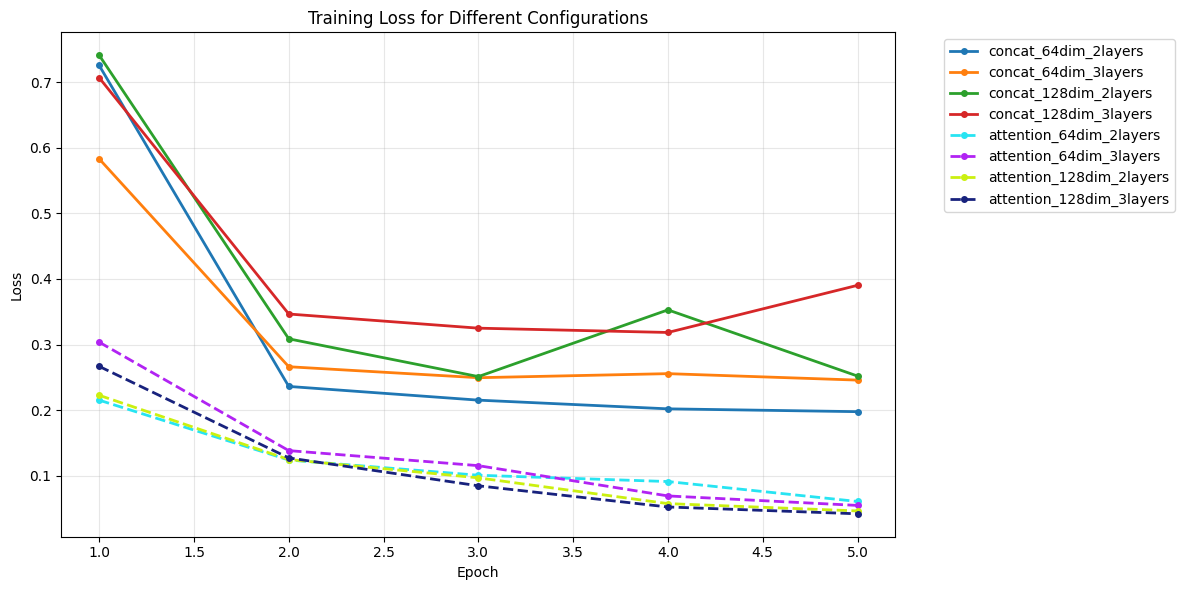

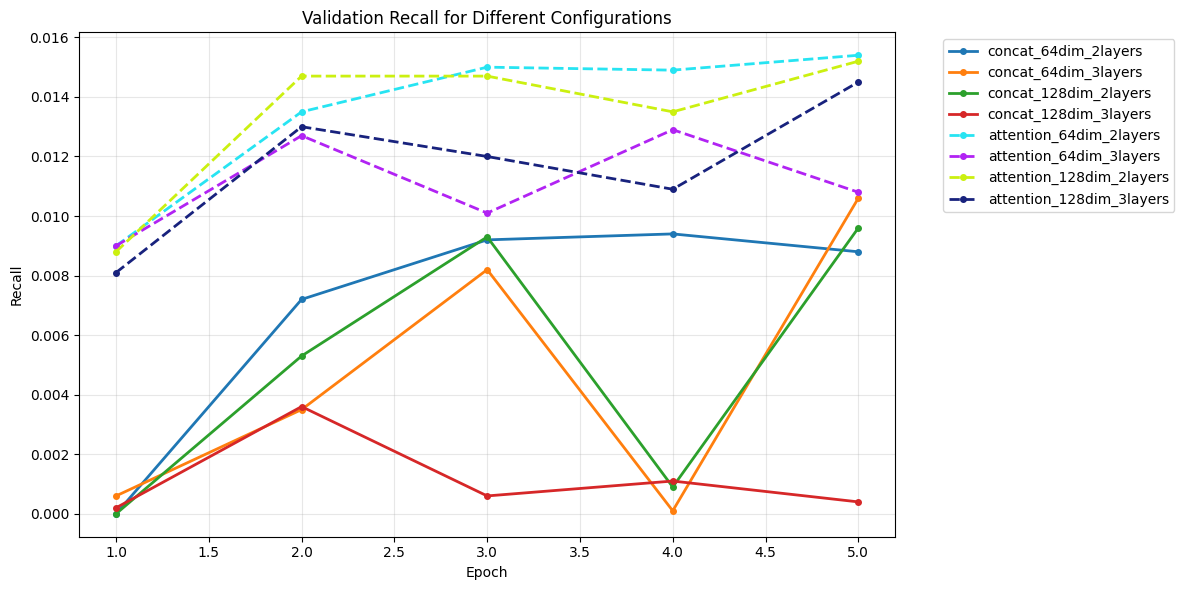

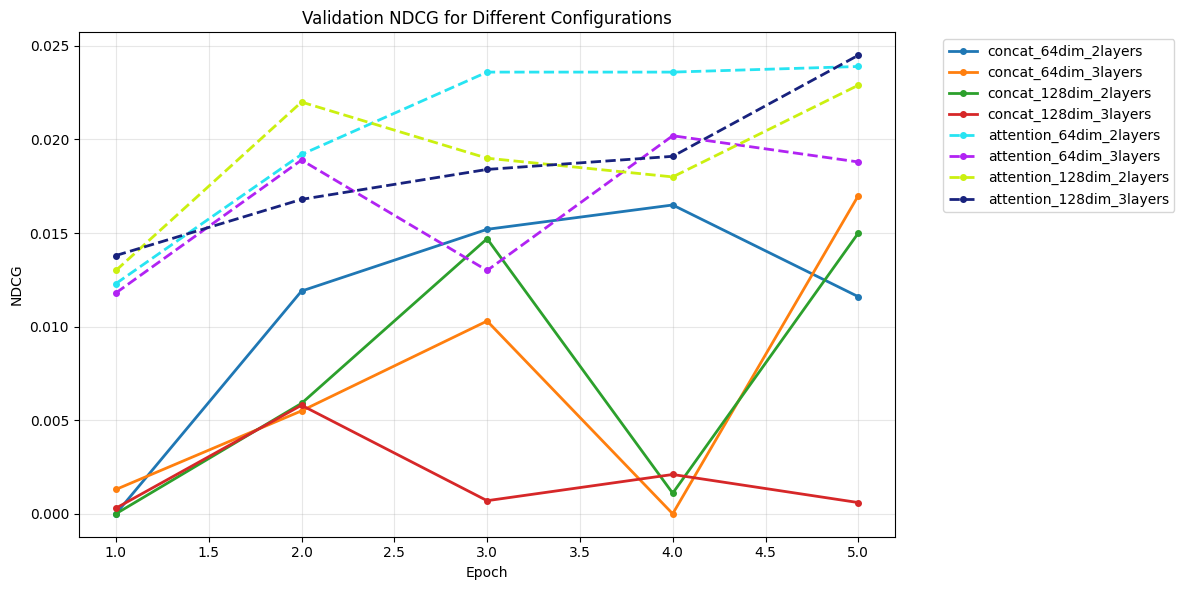

In [1]:
import matplotlib.pyplot as plt
import json

with open("histories.json", "r", encoding='utf-8') as file:
    data = json.load(file)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
          "#27e4f2", "#b123f3", "#cbf010", "#18227D"]

line_styles = {'concat': '-', 'attention': '--'}

def get_simple_name(full_name):
    parts = full_name.split('_')
    fusion_type = 'concat' if 'concat' in full_name else 'attention'
    dim = parts[3]
    layers = parts[6]
    return f"{fusion_type}_{dim}dim_{layers}layers"

plt.figure(figsize=(12, 6))
epochs = range(1, 6)

for idx, (config_name, metrics) in enumerate(data.items()):
    line_style = line_styles['concat'] if 'concat' in config_name else line_styles['attention']
    simple_name = get_simple_name(config_name)
    
    plt.plot(epochs, metrics['loss'], 
             label=simple_name, color=colors[idx],
             linestyle=line_style, linewidth=2, marker='o', markersize=4)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for Different Configurations')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
for idx, (config_name, metrics) in enumerate(data.items()):
    line_style = line_styles['concat'] if 'concat' in config_name else line_styles['attention']
    simple_name = get_simple_name(config_name)
    
    plt.plot(epochs, metrics['val_recall'], 
             label=simple_name, color=colors[idx],
             linestyle=line_style, linewidth=2, marker='o', markersize=4)

plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Validation Recall for Different Configurations')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

for idx, (config_name, metrics) in enumerate(data.items()):
    line_style = line_styles['concat'] if 'concat' in config_name else line_styles['attention']
    simple_name = get_simple_name(config_name)
    
    plt.plot(epochs, metrics['val_ndcg'], 
             label=simple_name, color=colors[idx],
             linestyle=line_style, linewidth=2, marker='o', markersize=4)

plt.xlabel('Epoch')
plt.ylabel('NDCG')
plt.title('Validation NDCG for Different Configurations')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()